In [36]:
# Names: Caylum Hurley (22356363), Joe Considine (22344977), Darragh Quinn (22359621)
# Code executes to the end without errors
# Links to third-party implementations used for the submission: https://ale.farama.org/environments/

Names: Caylum Hurley (22356363), Joe Considine (22344977), Darragh Quinn (22359621)
Code executes to the end without errors
Links to third-party implementations used for the submission: https://ale.farama.org/environments/

In [37]:
#Install gynasium with Atari support

%pip install gymnasium[atari,accept-rom-license] ale-py
%pip install --upgrade pip
%pip install opencv-python
%pip install torch torchvision torchaudio

In [38]:
#imports

import sys
print(sys.executable)
print(sys.version)
import numpy as np
import gymnasium as gym
import ale_py
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm


from collections import deque

stack_size = 4

/usr/bin/python3
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [39]:
#Registering the Atari environments from the ALE

gym.register_envs(ale_py)

Creating the Pong environment. The rgb_array captures frames for preprocessing and video generation.

In [40]:
#Creates Pong environment
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

#Reset the enviornment for initial observation
observation, info = env.reset()

#Verifying setup
print("Observation shape: ", observation.shape)
print("Action shape: ", env.action_space)

Observation shape:  (210, 160, 3)
Action shape:  Discrete(6)


Preprocessing Observation. Since the raw images given are RGB images, we need to convert each frame to grayscale, resize to 84*84 pixels, and normalise pixel values to a range [0, 1]. Doing this makes learning efficiency much better as opposed to processing the images directly.

In [41]:
def preprocess_observation(observation):
    gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY) #RGB to grayscale
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA) #Resize to DQN input size
    normalised = resized / 255.0 #Normalise pixel values

    return normalised

In [42]:
#TODO should min and max be 0 and 1?
#Test preprocessing

processed_observation = preprocess_observation(observation)

print("Processed shape: ", processed_observation.shape)
print("Minimum pixel value: ", processed_observation.min())
print("Maximum pixel value: ", processed_observation.max())

Processed shape:  (84, 84)
Minimum pixel value:  0.25098039215686274
Maximum pixel value:  0.7019607843137254


Our DQN takes the preprocessed game frame as the input and outputs a Q-value for each possible action. The action with the highest Q-value is chosen as the agent's policy action during exploitation. Our architecture uses three convolutional layers for spatial feature extraction, two fully connected layers for decision making, and a final linear output that produces our Q-value.

Convolutional layers detect the ball and the paddles in their relative positions.

ReLU used to introduce non-linearity so that the model can learn more complex scenarios.

Fully connected layers combine the extracted features for a Q-value estimate.

Output layer has one neuron per action, producing the award for each action.

In [43]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()

        #Convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=stack_size, # Input is a single, preprocessed grayscale image of shape (1, 84, 84)
            out_channels=32,
            kernel_size=8,
            stride=4
        )

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=2
        )

        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1
        )

        self.fc1 = nn.Linear(7*7*64, 512) #Feature map size (7*7*64)

        self.fc2 = nn.Linear(512, n_actions) #One Q-value per action

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1) #Flatten tensor for fully connected layers

        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)

        return q_values

Creating Target and Online Networks

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Number of actions
n_actions = env.action_space.n

#Creates Q-network
policy_net = DQN(n_actions).to(device)

#Creates target Q-network
target_net = DQN(n_actions).to(device)

#Copy weights from policy to target network
target_net.load_state_dict(policy_net.state_dict())

#Setting target mode to evaluation mode
target_net.eval()

cuda


DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)

In [45]:
#Converting a preprocessed frame into a tensor
state_tensor = torch.tensor(np.stack([processed_observation]*stack_size, axis=0), dtype=torch.float32).unsqueeze(0).to(device)
print(state_tensor.shape)  # should be (1, 4, 84, 84)

#Pass state through online network
with torch.no_grad():
    q_values = policy_net(state_tensor)

#Print Q-Values
print("Q-values: ", q_values)
print("Q-values shape: ", q_values.shape)

torch.Size([1, 4, 84, 84])
Q-values:  tensor([[ 0.0349, -0.0077, -0.0217, -0.0026,  0.0304,  0.0197]],
       device='cuda:0')
Q-values shape:  torch.Size([1, 6])


We are using a Replay Buffer to store transitions explored by the agent in the environment. Replay is very important for stabilising DQN training. The agent samples random mini-batches from the replay buffer. Doing it this way improves data efficiency by reusing experiences and it breaks temporal correlations between consecutive frames.

In [46]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) #Appends a tuple

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

We are giving the replay buffer a large capacity to ensure a diverse set of experiences are available for training. When buffer is filled, older experiences are discarded automatically. This reduces overfitting and makes training more stable.

At the start of training, the replay buffer does not contain enough transitions to form a mini-batch. Training updates are therefore skipped until the buffer has a sufficient number of experiences.

In [47]:
replay_buffer = ReplayBuffer(capacity=1000)

for i in range(5):
    stacked_test_frame = np.stack([processed_observation]*stack_size, axis=0)
    replay_buffer.push(
        stacked_test_frame,
        env.action_space.sample(),
        1.0,
        stacked_test_frame,
        False
    )

    print("Replay buffer size: ", len(replay_buffer))

    batch_size = 2 # must be <= buffer size

    if len(replay_buffer) >= batch_size:
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        print("Sampled batch size: ", len(states))
        print("Sampled actions: ", actions)
    else:
        print("Not enough samples in replay buffer to sample a batch yet")

Replay buffer size:  1
Not enough samples in replay buffer to sample a batch yet
Replay buffer size:  2
Sampled batch size:  2
Sampled actions:  (np.int64(2), np.int64(0))
Replay buffer size:  3
Sampled batch size:  2
Sampled actions:  (np.int64(2), np.int64(0))
Replay buffer size:  4
Sampled batch size:  2
Sampled actions:  (np.int64(1), np.int64(4))
Replay buffer size:  5
Sampled batch size:  2
Sampled actions:  (np.int64(4), np.int64(1))


In [48]:
episodes = 750
batch_size = 32
gamma = 0.99
learning_rate = 1e-4
target_update = 1000
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
steps_completed = 0

In [49]:
#def choose_action(state, epsilon):
    #if random.random() < epsilon:
        #return env.action_space.sample()
    #else:
        #with torch.no_grad():
            #return policy_net(state).argmax().item()

In [50]:
def choose_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            return policy_net(state_tensor).argmax(dim=1).item()

Don't know if Caylum is going to write part of the markdown for below cell but I am writing a bit about the maximisation bias

We reduceded maximation bias with Double DQN in the below cell. The policy network picks the next best action while the target network evaluates the value of the chosen action. The result is a more accurate target estimate and greater training stability. This leads to much more consitent performance in our Pong environment.

In [51]:
import torch

def training_step():
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Convert numpy arrays to PyTorch tensors
    states = [torch.tensor(state, dtype=torch.float32).unsqueeze(0) if state.ndim == 2 else torch.tensor(state, dtype=torch.float32) for state in states]
    next_states = [torch.tensor(state, dtype=torch.float32).unsqueeze(0) if state.ndim == 2 else torch.tensor(state, dtype=torch.float32) for state in next_states]


    # Concatenate tensors
    states = torch.stack(states).to(device)
    next_states = torch.stack(next_states).to(device)

    actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)

    dones = dones.float()

    # Continue with the rest of the training logic...

    q_vals = policy_net(states).gather(1, actions)

    #Double DQN to fix maximization bias
    with torch.no_grad():
        next_actions = policy_net(next_states).argmax(dim=1, keepdim=True) # Get actions from policy network
        next_q_vals = target_net(next_states).gather(1, next_actions) # Action evaluation from target network
        target_q_vals = rewards + (gamma * next_q_vals * (1 - dones))

    loss = F.mse_loss(q_vals, target_q_vals)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [52]:
episode_rewards = []

for episode in tqdm(range(episodes), desc="Training Episodes"):
    observation, info = env.reset()

    stacked_frames = deque(maxlen=stack_size)

    frame = preprocess_observation(observation)

    for _ in range(stack_size):
        stacked_frames.append(frame)

    state = np.stack(stacked_frames, axis=0)  # Shape: (stack_size, 84, 84)

    total_reward = 0.0
    done = False

    while not done:
        steps_completed += 1

        action = choose_action(state, epsilon)
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_frame = preprocess_observation(next_observation)
        stacked_frames.append(next_frame)
        next_state = np.stack(stacked_frames, axis=0)

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            training_step()

        if steps_completed % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")



Training Episodes:   0%|          | 1/750 [00:15<3:12:19, 15.41s/it]

Episode 0, Total Reward: -19.0, Epsilon: 0.995


Training Episodes:   1%|▏         | 11/750 [01:45<2:01:21,  9.85s/it]

Episode 10, Total Reward: -19.0, Epsilon: 0.946


Training Episodes:   3%|▎         | 21/750 [03:11<1:47:22,  8.84s/it]

Episode 20, Total Reward: -20.0, Epsilon: 0.900


Training Episodes:   4%|▍         | 31/750 [04:37<1:40:23,  8.38s/it]

Episode 30, Total Reward: -21.0, Epsilon: 0.856


Training Episodes:   5%|▌         | 41/750 [06:05<1:44:11,  8.82s/it]

Episode 40, Total Reward: -20.0, Epsilon: 0.814


Training Episodes:   7%|▋         | 51/750 [07:34<1:46:48,  9.17s/it]

Episode 50, Total Reward: -20.0, Epsilon: 0.774


Training Episodes:   8%|▊         | 61/750 [09:02<1:41:10,  8.81s/it]

Episode 60, Total Reward: -20.0, Epsilon: 0.737


Training Episodes:   9%|▉         | 71/750 [10:32<1:38:09,  8.67s/it]

Episode 70, Total Reward: -21.0, Epsilon: 0.701


Training Episodes:  11%|█         | 81/750 [12:07<1:45:26,  9.46s/it]

Episode 80, Total Reward: -19.0, Epsilon: 0.666


Training Episodes:  12%|█▏        | 91/750 [13:50<1:53:14, 10.31s/it]

Episode 90, Total Reward: -21.0, Epsilon: 0.634


Training Episodes:  13%|█▎        | 101/750 [15:31<1:46:04,  9.81s/it]

Episode 100, Total Reward: -21.0, Epsilon: 0.603


Training Episodes:  15%|█▍        | 111/750 [17:23<2:02:19, 11.49s/it]

Episode 110, Total Reward: -17.0, Epsilon: 0.573


Training Episodes:  16%|█▌        | 121/750 [19:18<2:00:36, 11.50s/it]

Episode 120, Total Reward: -18.0, Epsilon: 0.545


Training Episodes:  17%|█▋        | 131/750 [21:04<1:47:06, 10.38s/it]

Episode 130, Total Reward: -20.0, Epsilon: 0.519


Training Episodes:  19%|█▉        | 141/750 [23:04<2:03:49, 12.20s/it]

Episode 140, Total Reward: -20.0, Epsilon: 0.493


Training Episodes:  20%|██        | 151/750 [24:59<2:07:34, 12.78s/it]

Episode 150, Total Reward: -17.0, Epsilon: 0.469


Training Episodes:  21%|██▏       | 161/750 [27:07<2:03:19, 12.56s/it]

Episode 160, Total Reward: -18.0, Epsilon: 0.446


Training Episodes:  23%|██▎       | 171/750 [29:17<2:13:08, 13.80s/it]

Episode 170, Total Reward: -16.0, Epsilon: 0.424


Training Episodes:  24%|██▍       | 181/750 [31:21<1:54:39, 12.09s/it]

Episode 180, Total Reward: -19.0, Epsilon: 0.404


Training Episodes:  25%|██▌       | 191/750 [33:39<2:14:27, 14.43s/it]

Episode 190, Total Reward: -21.0, Epsilon: 0.384


Training Episodes:  27%|██▋       | 201/750 [35:58<2:11:23, 14.36s/it]

Episode 200, Total Reward: -18.0, Epsilon: 0.365


Training Episodes:  28%|██▊       | 211/750 [38:18<2:02:44, 13.66s/it]

Episode 210, Total Reward: -21.0, Epsilon: 0.347


Training Episodes:  29%|██▉       | 221/750 [40:27<1:51:36, 12.66s/it]

Episode 220, Total Reward: -18.0, Epsilon: 0.330


Training Episodes:  31%|███       | 231/750 [43:01<2:19:08, 16.08s/it]

Episode 230, Total Reward: -20.0, Epsilon: 0.314


Training Episodes:  32%|███▏      | 241/750 [45:41<2:08:02, 15.09s/it]

Episode 240, Total Reward: -18.0, Epsilon: 0.299


Training Episodes:  33%|███▎      | 251/750 [48:19<2:06:16, 15.18s/it]

Episode 250, Total Reward: -15.0, Epsilon: 0.284


Training Episodes:  35%|███▍      | 261/750 [50:47<2:07:25, 15.64s/it]

Episode 260, Total Reward: -14.0, Epsilon: 0.270


Training Episodes:  36%|███▌      | 271/750 [53:12<1:54:59, 14.40s/it]

Episode 270, Total Reward: -19.0, Epsilon: 0.257


Training Episodes:  37%|███▋      | 281/750 [55:50<1:59:51, 15.33s/it]

Episode 280, Total Reward: -17.0, Epsilon: 0.245


Training Episodes:  39%|███▉      | 291/750 [58:07<1:42:51, 13.45s/it]

Episode 290, Total Reward: -20.0, Epsilon: 0.233


Training Episodes:  40%|████      | 301/750 [1:00:51<1:55:03, 15.38s/it]

Episode 300, Total Reward: -16.0, Epsilon: 0.221


Training Episodes:  41%|████▏     | 311/750 [1:03:25<1:47:36, 14.71s/it]

Episode 310, Total Reward: -21.0, Epsilon: 0.210


Training Episodes:  43%|████▎     | 321/750 [1:05:48<1:43:47, 14.52s/it]

Episode 320, Total Reward: -15.0, Epsilon: 0.200


Training Episodes:  44%|████▍     | 331/750 [1:08:40<1:55:31, 16.54s/it]

Episode 330, Total Reward: -20.0, Epsilon: 0.190


Training Episodes:  45%|████▌     | 341/750 [1:11:20<1:51:11, 16.31s/it]

Episode 340, Total Reward: -15.0, Epsilon: 0.181


Training Episodes:  47%|████▋     | 351/750 [1:14:15<1:57:13, 17.63s/it]

Episode 350, Total Reward: -18.0, Epsilon: 0.172


Training Episodes:  48%|████▊     | 361/750 [1:17:10<1:56:54, 18.03s/it]

Episode 360, Total Reward: -18.0, Epsilon: 0.164


Training Episodes:  49%|████▉     | 371/750 [1:20:17<1:55:22, 18.26s/it]

Episode 370, Total Reward: -11.0, Epsilon: 0.156


Training Episodes:  51%|█████     | 381/750 [1:23:10<1:45:51, 17.21s/it]

Episode 380, Total Reward: -17.0, Epsilon: 0.148


Training Episodes:  52%|█████▏    | 391/750 [1:26:05<1:49:11, 18.25s/it]

Episode 390, Total Reward: -18.0, Epsilon: 0.141


Training Episodes:  53%|█████▎    | 401/750 [1:29:13<1:53:01, 19.43s/it]

Episode 400, Total Reward: -18.0, Epsilon: 0.134


Training Episodes:  55%|█████▍    | 411/750 [1:32:07<1:35:11, 16.85s/it]

Episode 410, Total Reward: -18.0, Epsilon: 0.127


Training Episodes:  56%|█████▌    | 421/750 [1:34:42<1:27:24, 15.94s/it]

Episode 420, Total Reward: -21.0, Epsilon: 0.121


Training Episodes:  57%|█████▋    | 431/750 [1:37:50<1:41:42, 19.13s/it]

Episode 430, Total Reward: -16.0, Epsilon: 0.115


Training Episodes:  59%|█████▉    | 441/750 [1:40:54<1:33:56, 18.24s/it]

Episode 440, Total Reward: -18.0, Epsilon: 0.110


Training Episodes:  60%|██████    | 451/750 [1:43:09<1:01:51, 12.41s/it]

Episode 450, Total Reward: -17.0, Epsilon: 0.104


Training Episodes:  61%|██████▏   | 461/750 [1:45:47<1:12:01, 14.95s/it]

Episode 460, Total Reward: -19.0, Epsilon: 0.099


Training Episodes:  63%|██████▎   | 471/750 [1:48:22<1:11:16, 15.33s/it]

Episode 470, Total Reward: -17.0, Epsilon: 0.094


Training Episodes:  64%|██████▍   | 481/750 [1:51:19<1:19:25, 17.72s/it]

Episode 480, Total Reward: -19.0, Epsilon: 0.090


Training Episodes:  65%|██████▌   | 491/750 [1:54:11<1:09:03, 16.00s/it]

Episode 490, Total Reward: -16.0, Epsilon: 0.085


Training Episodes:  67%|██████▋   | 501/750 [1:56:51<1:06:36, 16.05s/it]

Episode 500, Total Reward: -19.0, Epsilon: 0.081


Training Episodes:  68%|██████▊   | 511/750 [1:59:25<1:00:26, 15.17s/it]

Episode 510, Total Reward: -20.0, Epsilon: 0.077


Training Episodes:  69%|██████▉   | 521/750 [2:02:11<1:06:09, 17.33s/it]

Episode 520, Total Reward: -18.0, Epsilon: 0.073


Training Episodes:  71%|███████   | 531/750 [2:05:00<1:05:23, 17.92s/it]

Episode 530, Total Reward: -12.0, Epsilon: 0.070


Training Episodes:  72%|███████▏  | 541/750 [2:07:26<53:48, 15.45s/it]

Episode 540, Total Reward: -17.0, Epsilon: 0.066


Training Episodes:  73%|███████▎  | 551/750 [2:10:06<55:53, 16.85s/it]

Episode 550, Total Reward: -17.0, Epsilon: 0.063


Training Episodes:  75%|███████▍  | 561/750 [2:13:10<1:02:26, 19.82s/it]

Episode 560, Total Reward: -14.0, Epsilon: 0.060


Training Episodes:  76%|███████▌  | 571/750 [2:15:38<49:05, 16.45s/it]

Episode 570, Total Reward: -12.0, Epsilon: 0.057


Training Episodes:  77%|███████▋  | 581/750 [2:18:03<39:10, 13.91s/it]

Episode 580, Total Reward: -18.0, Epsilon: 0.054


Training Episodes:  79%|███████▉  | 591/750 [2:20:44<45:38, 17.22s/it]

Episode 590, Total Reward: -18.0, Epsilon: 0.052


Training Episodes:  80%|████████  | 601/750 [2:23:23<38:59, 15.70s/it]

Episode 600, Total Reward: -16.0, Epsilon: 0.049


Training Episodes:  81%|████████▏ | 611/750 [2:26:33<42:55, 18.53s/it]

Episode 610, Total Reward: -17.0, Epsilon: 0.047


Training Episodes:  83%|████████▎ | 621/750 [2:29:14<36:32, 16.99s/it]

Episode 620, Total Reward: -17.0, Epsilon: 0.044


Training Episodes:  84%|████████▍ | 631/750 [2:32:14<34:56, 17.62s/it]

Episode 630, Total Reward: -14.0, Epsilon: 0.042


Training Episodes:  85%|████████▌ | 641/750 [2:34:48<31:21, 17.26s/it]

Episode 640, Total Reward: -16.0, Epsilon: 0.040


Training Episodes:  87%|████████▋ | 651/750 [2:37:16<25:23, 15.39s/it]

Episode 650, Total Reward: -19.0, Epsilon: 0.038


Training Episodes:  88%|████████▊ | 661/750 [2:40:13<24:59, 16.85s/it]

Episode 660, Total Reward: -17.0, Epsilon: 0.036


Training Episodes:  89%|████████▉ | 671/750 [2:42:48<20:33, 15.61s/it]

Episode 670, Total Reward: -18.0, Epsilon: 0.035


Training Episodes:  91%|█████████ | 681/750 [2:45:21<18:38, 16.21s/it]

Episode 680, Total Reward: -19.0, Epsilon: 0.033


Training Episodes:  92%|█████████▏| 691/750 [2:48:12<16:34, 16.85s/it]

Episode 690, Total Reward: -19.0, Epsilon: 0.031


Training Episodes:  93%|█████████▎| 701/750 [2:51:05<13:56, 17.06s/it]

Episode 700, Total Reward: -17.0, Epsilon: 0.030


Training Episodes:  95%|█████████▍| 711/750 [2:53:45<11:19, 17.42s/it]

Episode 710, Total Reward: -14.0, Epsilon: 0.028


Training Episodes:  96%|█████████▌| 721/750 [2:56:17<07:02, 14.56s/it]

Episode 720, Total Reward: -15.0, Epsilon: 0.027


Training Episodes:  97%|█████████▋| 731/750 [2:59:26<06:35, 20.81s/it]

Episode 730, Total Reward: -11.0, Epsilon: 0.026


Training Episodes:  99%|█████████▉| 741/750 [3:02:20<02:14, 14.93s/it]

Episode 740, Total Reward: -18.0, Epsilon: 0.024


Training Episodes: 100%|██████████| 750/750 [3:05:19<00:00, 14.83s/it]


Results before DDQN
![alt text](image.png)

![image.png](attachment:image.png)

After DDQN
![alt text](image-1.png)

![image-2.png](attachment:image-2.png)

Would probably want to see difference with more data.

Might need to find a way to train the model faster or more efficiently apart from using DDQN. Ideas might be adding frame stacking or upping number of episodes. Maybe different loss function like Huber loss.

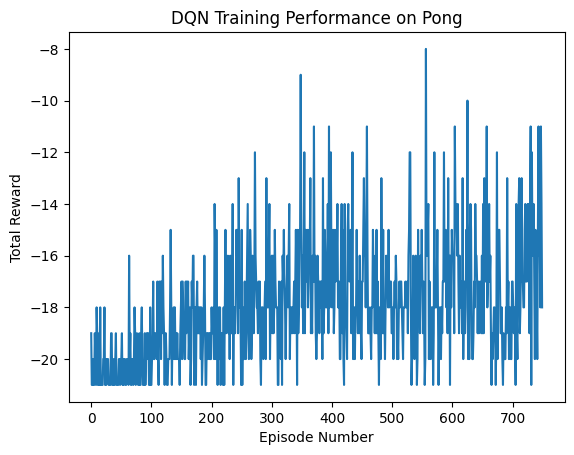

In [53]:
# Episode Reward Plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(episode_rewards)
plt.xlabel("Episode Number")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance on Pong")
plt.show()


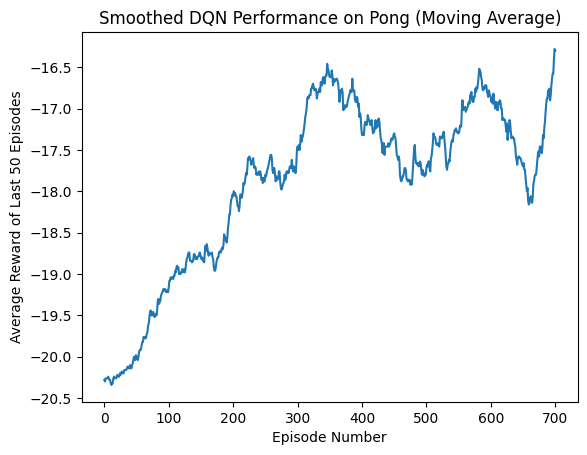

In [54]:
# Smoothed Rewards of Results
def smooth_rewards(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_rewards = smooth_rewards(episode_rewards, window_size=50)

plt.figure()
plt.plot(smoothed_rewards)
plt.xlabel("Episode Number")
plt.ylabel("Average Reward of Last 50 Episodes")
plt.title("Smoothed DQN Performance on Pong (Moving Average)")
plt.show()


In [55]:
#Markdown cell for Learning update (Will update soon)

References:

Double DQN - https://www.emergentmind.com/topics/double-q-learning-algorithm

